## Workshop 8: Bayesian Inference with Regression

*Note:* Chrome displays a vertical bar after all maths expressions. This is not intentional, it's a display bug. If this annoys you, please use a different browser.

In this workshop we will be looking at Bayesian linear regression. Briefly, this involves learning a linear regression model from a training set of *(x, y)* pairs, where *x* is a vector representing a data point and *y* is a real-valued response variable. Earlier we looked at ridge regression, which involved:
1. assuming a linear relationship between inputs and outputs, i.e., $y \approx \mathbf{x}' \mathbf{w}$ for all pairs
1. minimising the *residual sum of squares error*, that is finding the parameters $\hat{\mathbf{w}}$ that give the best fit to the training responses (subject to added *regularisation* term) 
1. using $\hat{\mathbf{w}}$ to make test inferences

Today we will look at *Bayesian* inference for the above model. In this case we don't follow steps 2 and 3 above, but rather formulate the *posterior* over the parameters, and make test inferences using *all settings of the parameters* weighted by their posterior probability. These operations can be solved exactly, using linear algebra.

### (Desperately) seeking posterior

Before diving into the implementation, let's recap the maths behind Bayesian linear regression. We assume the data was generated from a Normal distribution, with its mean a linear function of the input vector and constant variance $\sigma^2$ (assumed known, herein).   

$$ \newcommand\ys{\mathbf{y}}
\newcommand\xs{\mathbf{x}}
\newcommand\Xs{\mathbf{X}}
\newcommand\ws{\mathbf{w}}
\newcommand\Vs{\mathbf{V}}
\newcommand\Is{\mathbf{I}}
\begin{align*}
y &\sim \textrm{Normal}(\xs' \ws, \sigma^2) & \mbox{Likelihood}\\
\ws &\sim \textrm{Normal}(\mathbf{0}, \gamma^2 \mathbf{I}_D) & \mbox{Prior}
\end{align*}$$

The prior over the weights encourages low-magnitude weights, with parameter $\gamma^2$ controlling the variance.

Given this formulation, we next step is to find an expression for the posterior

$$
\begin{align*}
p(\ws | \Xs, \ys, \sigma^2) = \frac{ p(\ys | \Xs, \ws, \sigma^2) p(\ws) }{ p(\ys | \Xs) } \propto p(\ys | \Xs, \ws, \sigma^2) p(\ws)
\end{align*}
$$

where $\Xs$ are the training points (a matrix) and $\ys$ are a vector of the response values for each training point. 

Recall that this can be solved, resulting in a Normal distribution for the posterior. We'll come back to this later on.

## Data set

We'll generate a simple synthetic dataset with a tiny handful of points drawn from a simple quadratic function,
$$ y = 5(x-\frac{1}{2})^2 $$
with a small amount of added noise.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[[ 0.15287748]
 [ 0.15596061]
 [ 0.26479759]
 [ 0.38177833]
 [ 0.43374011]]


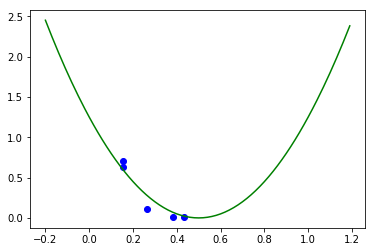

In [2]:
# generate a few points
N = 5
# each x is a scalar, uniformly drawn between [0, 1] 
X = np.sort(np.random.random(size=N))
# reshape X into a matrix, such that each instance is a row
X = X[:,np.newaxis]

#Fixed Run#3 for more clear uncertainty plot
#X2 = [ [0.18615756], [0.59675711] ,[0.67832224] ,[0.70492722] ,[0.89709031]]
#X = np.array(X2)

print(X)

# generate the target response values using the quadratic function
# and additive noise
sigma2 = 0.1**2
y = 5*(X-0.5)**2 + sigma2**0.5 * np.random.normal(size=(N,1))

# plot the training data
plt.plot(X, y, 'bo')

# and plot the true function (without noise)
Xp = np.arange(-0.2, 1.2, 0.01)
Xp = Xp[:,np.newaxis]
yp_gold = 5*(Xp-0.5)**2 
plt.plot(Xp, yp_gold, 'g')

### Polynomial basis functions

We'll fit this data with a polynomial model, considering a few different orders. Recall the basis function trick whereby you can augment the features of the input with new columns to implement a richer model class. Here we'll create a *basis matrix* for a $d^{th}$ order polynomial as follows

$$ \Phi = \begin{bmatrix}
    1 & x_1 & x_1^2 & x_1^3 & \ldots & x_1^d \\
    1 & x_2 & x_2^2 & x_2^3 & \ldots & x_2^d \\
    \vdots &    \vdots &    \vdots &\vdots &    \ddots & \vdots \\
    1 & x_n & x_n^2 & x_n^3 & \ldots & x_n^d \\
\end{bmatrix} $$

Observe how each row is a training point raised to a different power, from *0* to *d*. This means that when we take a row from $\Phi$ and take the dot product with $\mathbf{w}$, a parameter vector of size *d+1*, we obtain 

$$ \begin{align}
\Phi_{i} \mathbf{w} &= \sum_{j=0}^d \Phi_{ij} w_j \\
&= 1 \times w_0 + x_i \times w_1 + x_i^2 \times w_2 + \ldots + x_i^d \times w_d
\end{align}$$

I.e., a $d^{th}$ order polynomial expression with $\mathbf{w}$ giving the coefficients.

In [3]:
def polynomial_basis(X, Xtest, d):
    # ... Over to you
    
    return Phi, Phi_test

Phi, Phi_p = polynomial_basis(X, Xp, 9)
print (Phi.shape)

NameError: name 'Phi' is not defined

**Discussion**: How does this basis trick relate to kernel methods?

### Computing the posterior

Returning to the maths, the next step is to formulate the posterior. We plug in the Normal defintions of the likelihood and prior to solve for the unnormalised posterior

$$
\begin{align*}
p(\ws | \Xs, \ys, \sigma^2) & \propto \textrm{Normal}(\ws | \mathbf{0}, \gamma^2 \mathbf{I}_D)
\textrm{Normal}(\ys | \Xs \ws, \sigma^2 \mathbf{I}_N) \\
& \propto  \textrm{Normal}(\ws |  \ws_N, \mathbf{V}_N) \\
\mbox{where} ~ \ws_N &= \frac{1}{\sigma^2} \Vs_N \Phi' \ys \\
\Vs_N &= \sigma^2 ( \Phi' \Phi + \frac{\sigma^2}{\gamma^2} \Is_D )^{-1} 
\end{align*}
$$

which is (proportional to) a Normal distribution. As we know the normalising term for a Gaussian [the denominator of the PDF](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Non-degenerate_case), this means we have an exact normalised solution for the posterior, i.e.,  $p(\ws | \Xs, \ys, \sigma^2) = \textrm{Normal}(\ws |  \ws_N, \mathbf{V}_N)$.

Let's compute the mean vector and covariance matrix for the posterior based on the above expression.

In [ ]:
gamma2 = 100 # large number = more permissive, prior is broader
VN = # ... Over to you
wN = # ... Over to you
print(wN.shape, VN.shape)

Next, we can plot the prior and posterior to see how they differ; given we have several weights, we'll just look at a couple of these, $w_0$ and $w_1$. 

In [ ]:
# set up a 2d plot mesh
plt.figure(1)
delta = 0.05
xpl = np.arange(-3, 3, delta)
ypl = np.arange(-3, 3, delta)
Xpl, Ypl = np.meshgrid(xpl, ypl)

# plot a bivariate normal for the prior
Zpl = mlab.bivariate_normal(Xpl, Ypl, gamma2 ** 0.5,gamma2 ** 0.5, 0, 0, 0)
CS = plt.contour(Xpl, Ypl, Zpl) 
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Prior p(w) indices 0,1')

# plot a bivariate normal for the posterior
plt.figure(2)
Zpl = mlab.bivariate_normal(Xpl, Ypl, VN[0,0] ** 0.5, VN[1,1] ** 0.5, wN[0], wN[1], VN[0,1])
CS = plt.contour(Xpl, Ypl, Zpl) #, levels=[0.001, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5])
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Posterior p(w|X,y) indices 0,1')
plt.plot(wN[0], wN[1], 'rx')

**Discussion question**: Can you explain why the prior and the posterior are so different? How is this related to the dataset? Why are the elipses in the posterior not aligned to the axes? *You might want to change the parameter indices from 0,1 to other pairs to get a better idea of the full posterior.*

## Tim: 'w's are not independent anymore??

### Bayesian inference

The conceptually simplest means of doing inference is to draw a few parameter vectors from the posterior (sampling from a Gaussian). Let's do this 10 times and plot the results.

In [ ]:
# plot the data points
plt.plot(X, y, 'o')
# plot the mean prediction
yp = np.dot(Phi_p, wN)
plt.plot(Xp, yp, 'g-')

# generate some samples from the posterior
samples = []
ps = []
for s in range(10):
    # draw a weight vector
    w_sampled = np.random.multivariate_normal(wN.flatten(), VN, 1).flatten()
    # plot the predictions for this weight vector
    yp_sampled = np.dot(Phi_p, w_sampled)
    p = plt.plot(Xp.flatten(), yp_sampled.flatten(), ':', lw=3)
    samples.append(w_sampled)
    ps.append(p[0])
    
plt.ylim(-1,2)

It's interesting to see what happens near the data points, and away from them, in particular the edges of the plot. We'll come back to this.

But there's a more elegant solution, as the predictive distribution can be found in closed form. Namely

$$
\begin{align*}
p(y_{*} | \xs_{*}, \Xs, \ys, \sigma^2) &= \textrm{Normal}(y_{*} | \xs_{*}'\ws_N, \sigma^2_N(\xs_{*})) \\
\sigma^2_N(\xs_{*}) & = \sigma^2 + \xs_{*}' \Vs_N \xs_{*}
\end{align*}
$$

Note that the predictive mean is a simple application of the posterior mean to the data point, but the predictive variance is  a bit more complicated. Let's compute the mean and variance on the test points, and visualise the results.

In [ ]:
# compute the mean from above
yp = # ... Over to you

# compute the variance using formula above
s2s = np.zeros(Xp.shape[0])
for i in range(Xp.shape[0]):
    s2s[i] = # ... Over to you

# plot the data
plt.plot(X, y, 'o')
# plot the 95% confidence interval
plt.fill_between(Xp.flatten(), yp+2*s2s ** 0.5, yp-2*s2s ** 0.5, facecolor='blue', alpha=0.1)
# plot the mean as a green dotted line
plt.plot(Xp, yp, 'g:')
# plot the ground truth in red
plt.plot(Xp, yp_gold, 'r')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2,5)

**Discussion**: How does the uncertainty plot compare to the samples above? How does the uncertainty change relative to the distance from training points? Can you explain why?

**Practical**: How does the setting of *gamma2* affect the fit? How about the number of data points, *N*. Try some other values and see what happens. 

**Discussion**: Is a 9th order polynomial a good choice for this problem? Based on the results above, would you recommend this model, or make a different choice?

### Bayesian model selection

Now let's revisit the assumption of having a 9th order polynomial. The evidence gives us a good way of evaluating the quality of the fit. 

We can compute the evidence, $p(\ys|\Xs, \sigma^2, \gamma^2)$ <s>based on slide 31 of deck 14 (note the notation key, for mapping between Bishop to Murphy notation)</s>. This is also known as the *marginal likelihood* and is given in Bishop 3.5.1, p167 as equation 3.86. We won't delve into the details, but broadly speaking the $|\mathbf{A}|$ term penalises model complexity, while the $E$ term ($E(\mathbf{m}_N)$ in Bishop) measures the quality of the fit to the data.

In [ ]:
def log_evidence(m, Phi, sigma2, gamma2):
    N, M = Phi.shape
    alpha, beta = 1/float(gamma2), 1/float(sigma2)
    rss = np.sum((y - np.dot(Phi, m)) ** 2)
    wpen = np.dot(m.T, m)
    E = beta/2.0 * rss + alpha/2.0 * wpen
    A = alpha * np.eye(M) + beta * np.dot(Phi.T, Phi)
    lE = M/2.0 * np.log(alpha) + N/2.0 * np.log(beta) - E \
        - 0.5 * np.log(np.linalg.det(A)) - N/2.0 * np.log(2.0 * np.pi)

    # return both the evidence, and the RSS term (the raw quality of fit)
    return lE.flatten()[0], rss

# what's the evidence for our 9th order model?
print(log_evidence(wN, Phi, sigma2, gamma2))

So what happens if we use a lower order model, e.g., a 3rd order model?

In [ ]:
Phi3, Phi_p3 = polynomial_basis(X, Xp, 3)
VN3 = # ... Copy from above
wN3 = # ... Copy from above

yp3 = # ... Copy from above
s2s = np.zeros(Phi_p3.shape[0])
for i in range(Phi_p3.shape[0]):
    
    s2s[i] = # ... Copy from above
    
plt.plot(X, y, 'o')
plt.fill_between(Xp.flatten(), yp3+2*s2s ** 0.5, yp3-2*s2s ** 0.5, facecolor='blue', alpha=0.1)
plt.plot(Xp, yp3, 'g:')
plt.plot(Xp, yp_gold, 'r')
plt.xlabel('x')
plt.ylabel('y')

**Discussion**: does that look like a better fit to you? Consider both the area [0,1] near the training points, and those outside this range.

Let's see what the *evidence* says, and compare this to the above result:

In [ ]:
# ... Over to you

The RSS has barely changed, but the evidence is much higher. We can look at various model orders to see which has the best *evidence* to perform Bayesian model selection: 

In [ ]:
evs = []
gamma2 = 1000
for order in range(0,10):
    Phio, Phipo = polynomial_basis(X, Xp, order)
    Vo = # ... Copy from above
    wo = # ... Copy from above
    lEo = # ... Copy from above
    print('order', order, 'log evidence', lEo[0], 'rss', lEo[1])
    evs.append((order,) + lEo)

In [ ]:
#plot the above log evidence values against the model order
evs = np.vstack(evs)
plt.plot(evs[:,0], evs[:,1])
#plt.ylim(-100, -5)

**Discussion**: So which model class will be chosen? Is this a reasonable situation? 

**Practical**: Rerun the code with a new random training set, or different values of *N*, such as 2 or 3 points or 20; the results may be different. Can you explain why the outcome might be different?